##기본 셋팅

# "네이버영화 리뷰 감성분류하기"
( Naver Movie Review Sentiment Analysis )

데이터수 : 200,000개

관련 참고 : https://wikidocs.net/44249

텍스트파일의 데이터를 로드해와서 데이터의형태를 파악합니다.

이후 데이터정제를 통해 데이터를 전처리합니다.

전처리한 데이터로 학습모델을 만듭니다.

학습모델에 epoch값에따라 모델을 학습시키고, 가장 학습율이 우수한 모델을 최신 모델로 업데이트합니다.

In [92]:
!pip install tensorflow==2.0.0-rc1 # tensorflow 2.0설치하기, 2019년 12월기준 colab tensor 1.15.0, rnn사용하기위해

In [93]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy #형태소 분석기 konlpy설치 , 연습용

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 256 kB in 2s (117 kB/s)
Reading package lists... Done
Reading package lists... Done
B

In [94]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 가져오기
(load data sets)

In [95]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f95d0690390>)

In [96]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

### 훈련데이터 갯수 확인 및 데이터 형태

In [97]:
len(train_data)# 훈련용 리뷰 개수 출력

150000

In [98]:
len(test_data)# 테스트데이터 개수출력

50000

In [99]:
# train, test데이터 형태
# id, document, label 3개의열로 구성된 테이블
# id : comment 개인id
# document : 리뷰내용
# label : 긍,부정표시 (긍정:1,부정:0)
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [100]:
test_data.head(5) 

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 데이터정제를합니다. 중복된데이터가 있는지, 빈값이있는지 등을 확인하고 
### 데이터 분석전에 분석에 잡읍이 생기지 않도록 데이터를 처리해봅니다.

In [101]:
train_data['document'].nunique(), train_data['label'].nunique() # train_data['document']에 약 4000개의 중복셈플존재

(146182, 2)

In [102]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거


In [103]:
len(train_data) # 총 샘플수 : 146183 , 중복이 제거되었습니다.

146183

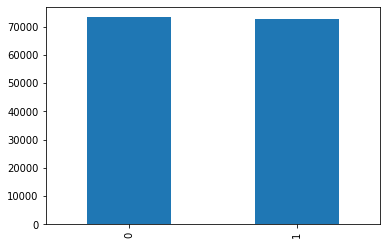

In [104]:
train_data['label'].value_counts().plot(kind = 'bar') # 'label'기준으로 긍, 부정인 리뷰갯수

In [105]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


In [106]:
train_data.isnull().values.any()# Null 값을 가진 샘플이 있는지는 Pandas의 isnull().values.any()로 확인합니다.

True

In [107]:
#NULL값을가진 샘플의 위치를 찾아봅니다.

In [108]:
train_data.isnull().sum() # document 열에 1개존재

id          0
document    1
label       0
dtype: int64

In [109]:
train_data.loc[train_data.document.isnull()] #위치

,id,document,label
25857,2172111,NaN,1


In [110]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.isnull().values.any() # Null 자료가 없습니다.

False

In [111]:
len(train_data)

146182

데이터 전처리


리뷰의 내용중, (.),(?),(!)등의 문자이외의 글자들을 제거합니다.

**이때 한글의 정규표현식(regular expression)을 이용합니다.

한글의 자음, 모음을 나타내는 정규 표현식을 찾아서 이것과 공백을 제외한 문자들은 제거해줍니다.

In [112]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 빼고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [113]:
#한글과 공백만 남긴채, 다른 문자들을 재거하니, null인 데이터가 391개 생겼습니다.
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    391
label         0
dtype: int64


In [114]:
train_data.loc[train_data.document.isnull()][:5] #null값을 가지는 데이터 출력

,id,document,label
584,7117896,NaN,0
593,6478189,NaN,0
638,9364602,NaN,0
668,1600635,NaN,0
1559,6918082,NaN,1


In [115]:
#해당 데이터들은 필요가없는 데이터들이므로 제거하였습니다.
train_data = train_data.dropna(how = 'any')
len(train_data)

145791

In [116]:
#테스트데이터에 트레인데이터와 마찬가지로 전처리를 해줍니다.
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995


##토큰화

In [117]:
#제일먼저 불용어(stop word)를 제거합니다
#불용어 : 자주등장하지만, 분석하는데에 큰 도움이되지 않는 단어들
#불용어는 필요에따라 사용자가 직접정의하기도함.

In [118]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [121]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [122]:
#train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [123]:
 len(X_train)

145791

In [124]:
X_train[:3]
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

##정수 인코딩
텍스트를 정수로 처리할 수 있도록 훈련데이터와 텍스트 데이터에 정수 인코딩을 수행합니다.
1. 토큰화된 단어들을기반으로 단어의집합을 만듭니다.
2. 빈도가 낮은 단어는 제거합니다.

for loop수행시 시간복잡도는?

In [125]:
#단어집합을 만듭니다.
tokenizer = Tokenizer() #토큰클래스
tokenizer.fit_on_texts(X_train) # 단어집합이 생성됨과동시에 고유번호가 부여됨

In [126]:
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '다': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '로': 17,
 '아니다': 18,
 '않다': 19,
 '점': 20,
 '에서': 21,
 '만들다': 22,
 '나오다': 23,
 '연기': 24,
 '것': 25,
 '평점': 26,
 '내': 27,
 '최고': 28,
 '그': 29,
 '나': 30,
 '안': 31,
 '인': 32,
 '스토리': 33,
 '생각': 34,
 '못': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '감동': 39,
 '사람': 40,
 '보고': 41,
 '이렇다': 42,
 '말': 43,
 '고': 44,
 '아깝다': 45,
 '더': 46,
 '배우': 47,
 '때': 48,
 'ㅋㅋ': 49,
 '아': 50,
 '감독': 51,
 '거': 52,
 '그냥': 53,
 '재미있다': 54,
 '요': 55,
 '재미': 56,
 '시간': 57,
 '내용': 58,
 '뭐': 59,
 '까지': 60,
 '중': 61,
 '주다': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '쓰레기': 67,
 '수': 68,
 '네': 69,
 '모르다': 70,
 '가다': 71,
 '들다': 72,
 '그렇다': 73,
 '싶다': 74,
 '지': 75,
 '작품': 76,
 '사랑': 77,
 '알다': 78,
 '하나': 79,
 '다시': 80,
 '마지막': 81,
 '볼': 82,
 '이건': 83,
 '정도': 84,
 '저': 85,
 '완전': 86,
 '오다': 87,
 'ㅋ': 88,
 'ㅠㅠ': 89,
 '많다': 90,
 '처음': 91,
 'ㅋㅋㅋ': 92,
 '장면': 9

In [127]:
#단어 등장 빈도수에따라 정수가부여됨, 높은정수 낮은빈도를 의미
#빈도수가 낮은 단어는 자연어 처리에서 배제
#등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items(): # word count라는 함수가 일정단어의 갯수를 세어줌 --> value값
    total_freq = total_freq + value #총 단어의갯수를 계산

    # 단어의 등장 빈도수가 threshold보다 작으면 rare_cnt++
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100) 

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [128]:
#단어비율 = 낮은단어 : 빈도높은단어 = 1:1
#전체 등장 빈도 = 낮은단어 등장빈도 : 높은단어 등장빈도 = 1.8 : 98.2
#따라서 희귀단어는 등장빈도가 매우낮으므로 배제합니다.

In [129]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [130]:
#이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로(인덱스 = 1,default) 변환합니다.
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [131]:
#정수인코딩 확인
#19417이상의 정수는 없음, 0과 1은 각각 패딩과 'oov'를 의미
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [132]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

###빈 샘플 제거
전체 데이터에서 빈도 수가 낮은 데이터가 삭제되었다 = 낮은 단어수로만 이루어진 샘플은 empty이다.
비어있는 샘플에는 레이블값이 의미가 없으므로 샘플을 제거합니다.

In [133]:
#길이가 0인 샘플들의 인덱스를 받아옴
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [134]:
# 빈 샘플들을 제거후 남은 데이터 갯수
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


###패딩
이제 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다.

전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


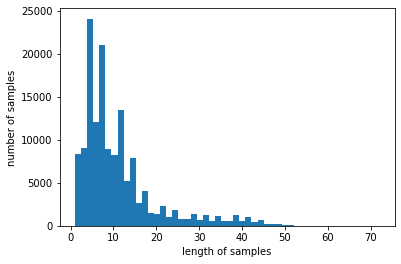

In [135]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [136]:
# 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 
# 특정 길이 변수를 max_len으로 정합니다.
# 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [137]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [138]:
#모든 셈플의 길이를 30으로 맞춥니다.
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

#LSTM으로 영화리뷰 감정분석하기
임베딩 벡터차원 : 100
분류하기위해 사용할 모델 : LSTM으로 정함

In [139]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [140]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [141]:
#검증데이터 손실이 증가하면, overfitting. 4회이상이면종료
#ModelCheckpoint이용, 이전모델보다 정확도가 높은 모델만 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [142]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Train on 116304 samples, validate on 29076 samples
Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
116280/116304 [============================>.] - ETA: 0s - loss: 0.3913 - acc: 0.8229
Epoch 00001: val_acc improved from -inf to 0.84475, saving model to best_model.h5
116304/116304 [==============================] - 216s 2ms/sample - loss: 0.3913 - acc: 0.8230 - val_loss: 0.3502 - val_acc: 0.8448
Epoch 2/15
116280/116304 [============================>.] - ETA: 0s - loss: 0.3281 - acc: 0.8571
Epoch 00002: val_acc improved from 0.84475 to 0.85407, saving model to best_model.h5
116304/116304 [==============================] - 211s 2ms/sample - loss: 0.3281 - acc: 0.8571 - val_loss: 0.3373 - val_acc: 0.8541
Epoch 3/15
116280/116304 [============================>.] - ETA: 0s - loss: 0.3021 - acc: 0.8712
Epoch 00003: val_acc improved from 0.85407 to 0.85847, saving model to best_model.h5
116304/116304 [==============================] - 2

In [143]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

48995/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [144]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [148]:
sentiment_predict('재밌다')

96.28% 확률로 긍정 리뷰입니다.

